In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import numpy as np
import sys
import os
from matplotlib import pyplot as plt
from matplotlib import cm

import pickle
import netCDF4 as nc

import climtools_lib as ctl
import climdiags as cd

from matplotlib.colors import LogNorm
from datetime import datetime

from scipy import stats
import xarray as xr
import glob
import xclim
import pymannkendall as mk

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
titlefont = 22
plt.rcParams['figure.titlesize'] = titlefont
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['legend.fontsize'] = 18

#############################################################################

cart_out = '/home/fabiano/Research/lavori/BOTTINO/ocean3d/'
ctl.mkdir(cart_out)

colors = ['black', 'lightslategray', 'forestgreen', 'orange', 'chocolate', 'maroon', 'violet']
allru = ['pi', 'b990', 'b025', 'b050', 'b065', 'b080', 'b100']


libgfortran.so.3: cannot open shared object file: No such file or directory
No DISPLAY variable set. Switching to agg backend


In [3]:
fia = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/stabilization-ssp585-2025/r1i1p1f1/Ofx/areacello/areacello_Ofx_EC-Earth3_stabilization-ssp585-2025_r1i1p1f1_gn.nc'

gigi_a = xr.load_dataset(fia, use_cftime = True)['areacello']

basnames = ['atlmsk', 'indmsk', 'pacmsk']
subbas = xr.load_dataset(cart_out + 'subbasins.nc')

areas = dict()
for basnam in basnames:
    pinzu = np.array(subbas[basnam])
    print(pinzu.shape)
    pinzu[pinzu == 0] = np.nan

    goggolo = gigi_a*pinzu
    areas[basnam] = goggolo.sum(['i', 'j'])


(292, 362)
(292, 362)
(292, 362)


In [4]:
gigi_a

<xarray.DataArray 'areacello' (j: 292, i: 362)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362
    latitude   (j, i) float64 -78.39 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
    longitude  (j, i) float64 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Ocean Variables
    comment:        Horizontal area of ocean grid cells
    units:          m2
    original_name:  areacello
    cell_methods:   area: sum

In [5]:
fig, axs = plt.subplots(1, 3, figsize = (16,7))

axs[0].imshow(subbas['atlmsk'])
axs[1].imshow(subbas['indmsk'])
axs[2].imshow(subbas['pacmsk'])

In [6]:
# pino = xr.load_dataset('/home/fabiano/work_big/cineka_bkp_0923/stabilization-ssp585-2100/r1i1p1f1/Omon/thetao/thetao_Omon_EC-Earth3_stabilization-ssp585-2100_r1i1p1f1_gn_210101-210112.nc', use_cftime = True)

# fia = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/stabilization-ssp585-2025/r1i1p1f1/Ofx/areacello/areacello_Ofx_EC-Earth3_stabilization-ssp585-2025_r1i1p1f1_gn.nc'
# fim = '/home/fabiano/work_big/cineka_bkp_0923/b00I/cmorized/cmor_2100/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/stabilization-ssp585-2100/r1i1p1f3/Omon/masscello/gn/v20220514/masscello_Omon_EC-Earth3_stabilization-ssp585-2100_r1i1p1f3_gn_210001-210012.nc'
# gigi_a = xr.load_dataset(fia, use_cftime = True)['areacello']
# gigi_m = xr.load_dataset(fim, use_cftime = True)['masscello']

# gigi = pino['thetao']

# oht = gigi*gigi_m.values*gigi_a.values[np.newaxis, np.newaxis, ...]

# gigi.shape, gigi_m.shape, gigi_a.shape

In [7]:
oht_all_basin = dict()

for ru in allru:
    print(ru)
    oht_lev = []
    oht_bas = dict()
    for basnam in basnames:
        oht_bas[basnam[:3]] = []

    filo = open(cart_out + f'oht_{ru}_1000_basin_ok.p', 'rb')
    for i in range(500):
        try:
            gigi = pickle.load(filo)
        except:
            break
        oht_lev.append(gigi[0])
        #print(np.nanmean(gigi, axis = 1))

        for basnam, gig in zip(basnames, gigi[1:]):
            oht_bas[basnam[:3]].append(gig)
        
    filo.close()

    oht_lev = xr.concat(oht_lev, dim = 'year')

    for basnam, gig in zip(basnames, gigi[1:]):
        oht_bas[basnam[:3]] = xr.concat(oht_bas[basnam[:3]], dim = 'year')
    
        oht_all_basin[(ru, 't_ini', basnam[:3])] = oht_bas[basnam[:3]][:30].mean('year')
        oht_all_basin[(ru, 't_final', basnam[:3])] = oht_bas[basnam[:3]][-30:].mean('year')

        if ru == 'pi':
            oht_all_basin[(ru, 't_ref', basnam[:3])] = oht_bas[basnam[:3]][70:120].mean('year')

pi


b990
b025
b050
b065
b080
b100


In [8]:
%matplotlib inline

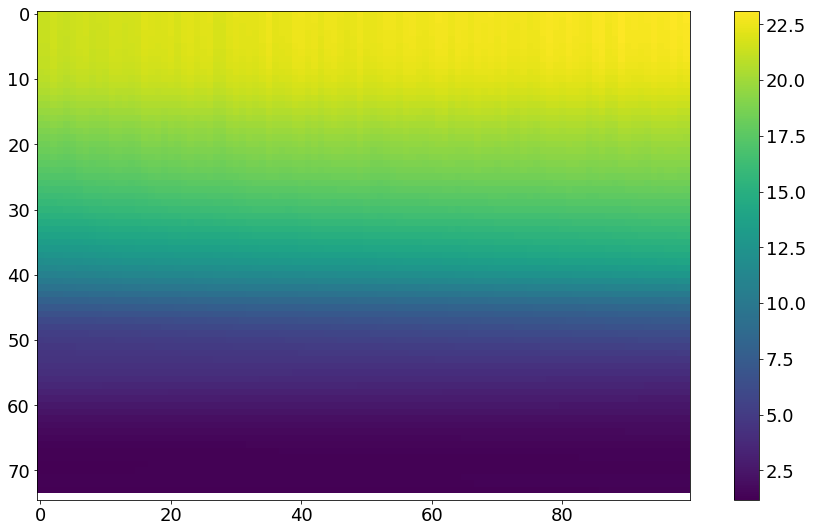

In [9]:
fig = plt.figure(figsize=(16,9))
plt.imshow(oht_bas['atl'][:100].T)
plt.colorbar()

atlmsk
indmsk
pacmsk


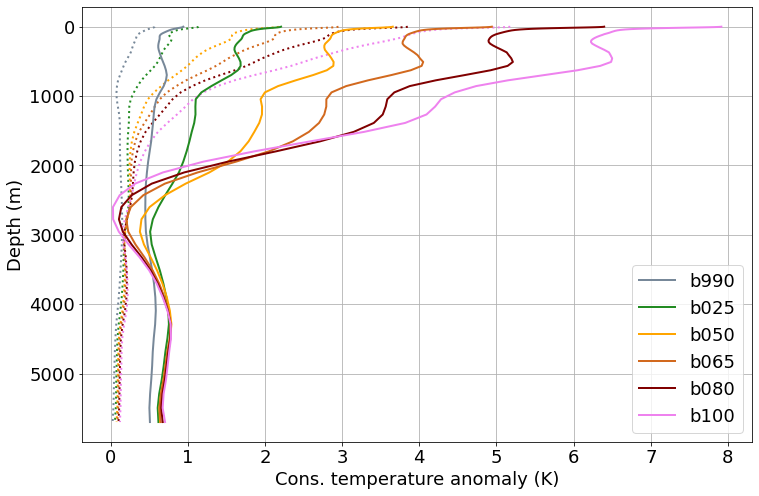

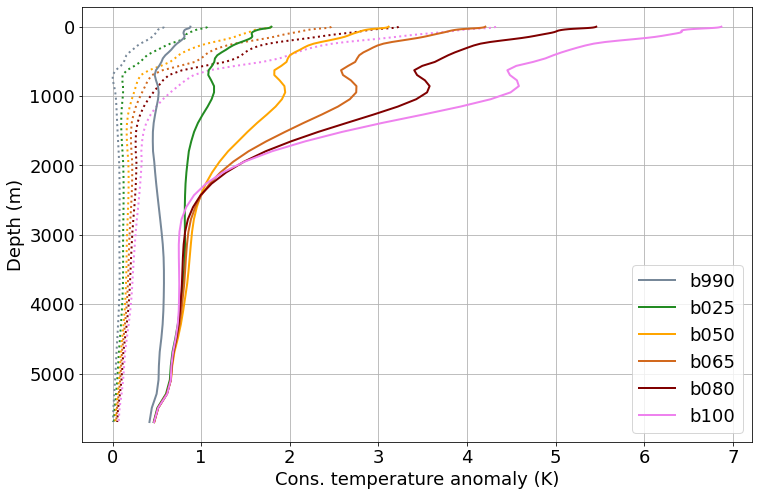

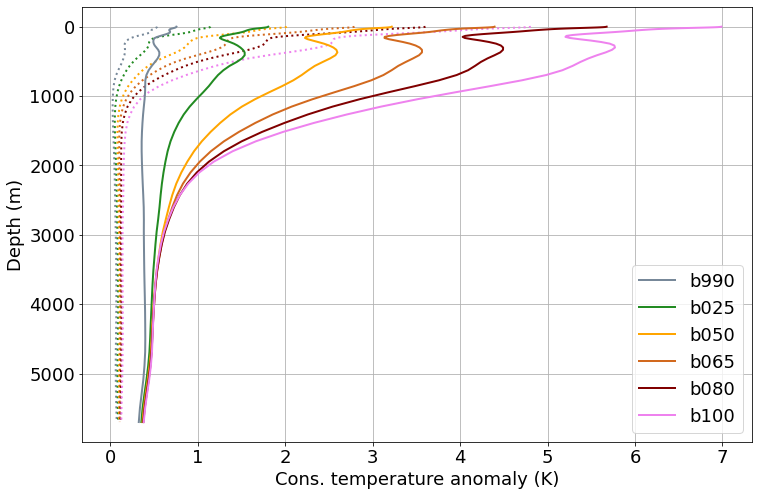

In [12]:
for basnam in areas:
    print(basnam)
    fig, ax = plt.subplots(figsize = (12,8))
    for ru, col in zip(allru[1:], colors[1:]):
        ax.plot(oht_all_basin[(ru, 't_ini', basnam[:3])]-oht_all_basin[('pi', 't_ref', basnam[:3])], oht_all_basin[(ru, 't_ini', basnam[:3])].lev, color = col, lw = 2, ls = ':')
    for ru, col in zip(allru[1:], colors[1:]):
        ax.plot(oht_all_basin[(ru, 't_final', basnam[:3])]-oht_all_basin[('pi', 't_ref', basnam[:3])], oht_all_basin[(ru, 't_final', basnam[:3])].lev, color = col, label = ru, lw = 2)
    ax.legend()
    ax.grid()
    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)')
    #ax.set_xlabel('Heat content anomaly (J)')
    ax.set_xlabel('Cons. temperature anomaly (K)')
    fig.savefig(cart_out + f'otemp_anom_vsini_profile_{basnam[:3]}.pdf')
